In [0]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install snorkel

In [0]:
import os, json, random, time, pickle
import xml.etree.ElementTree as ET
from math import sqrt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms.functional as FT
from torchvision import transforms as T
from snorkel.classification import cross_entropy_with_probs

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# For images saved in gdrive created from faster rcnn (didn't continue training classifier at the time)
# cannot use cp -r due to so many items and taking long time...
import os.path as osp
from shutil import copyfile

im_path = '/content/drive/My Drive/DL_projects/cv_fish/Faster_RCNN/test_cls'
if not os.path.exists('/content/test_cls'):
    os.mkdir('/content/test_cls')
for imfile in os.listdir(im_path):
    copyfile(osp.join(im_path, imfile), osp.join('/content/test_cls', imfile))

In [0]:
len(os.listdir('/content/test_cls'))

13153

### Download data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f train.zip

 99% 825M/832M [00:16<00:00, 62.8MB/s]
100% 832M/832M [00:16<00:00, 53.3MB/s]


In [0]:
!unzip -q train.zip

In [0]:
!rm train.zip

In [0]:
!rm train/.DS_Store

In [0]:
!rm -r __MACOSX

In [0]:
!cp -r /content/drive/My\ Drive/DL_projects/Data/fish_monitor/fish_bbox ./

In [0]:
!mkdir train_cls

### Prepare data

In [0]:
data_path = '/content'  # path of data files
label_clss = ['DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']
no_bbs = ['img_00568.jpg', 'img_01958.jpg', 'img_07008.jpg', 'img_00425.jpg',
          'img_04798.jpg', 'img_06460.jpg', 'img_02292.jpg', 'img_00576.jpg',
          'img_00379.jpg', 'img_06773.jpg', 'img_05444.jpg', 'img_06082.jpg',
          'img_03183.jpg', 'img_04558.jpg', 'img_02785.jpg']

In [0]:
!cp -r /content/train/* /content/train_cls/

In [0]:
!ls /content/train_cls

ALB  BET  DOL  LAG  NoF  OTHER	SHARK  YFT


In [0]:
# remove files that with many fish classes
for c in label_clss:
    for f in os.listdir(os.path.join(data_path, 'train_cls', c)):
        if f in no_bbs:
            os.remove(os.path.join(data_path, 'train_cls', c, f))

In [0]:
# only keep some of the original images
np.random.seed(135)
files = os.listdir(os.path.join(data_path, 'train', 'ALB'))
files_to_del = np.random.choice(files, int(len(files)/4), False)
for f in os.listdir(os.path.join(data_path, 'train_cls', 'ALB')):
    if f in files_to_del:
        os.remove(os.path.join(data_path, 'train_cls', 'ALB', f))

files = os.listdir(os.path.join(data_path, 'train', 'YFT'))
files_to_del = np.random.choice(files, int(len(files)/2), False)
for f in os.listdir(os.path.join(data_path, 'train_cls', 'YFT')):
    if f in files_to_del:
        os.remove(os.path.join(data_path, 'train_cls', 'YFT', f))

In [0]:
gt = {}
for c in label_clss:
    with open(os.path.join(data_path, 'fish_bbox', c.lower()+'_labels.json')) as f:
        gt[c] = json.load(f)

In [0]:
all_files = []
for c in label_clss:
    im_files = os.listdir(os.path.join(data_path, 'train', c))
    all_files += [c+'/'+f for f in im_files if f not in no_bbs]

In [0]:
%%time
for fpath in all_files:
    im = Image.open(os.path.join(data_path, 'train', fpath))
    clss, fname = fpath.split('/')
    mask = list(map(lambda x: x['filename'].split('/')[-1]==fname, gt[clss]))
    bbs = np.array(gt[clss])[mask][0]['annotations']

    boxes = [[b['x'], b['y'], (b['x']+b['width']), (b['y']+b['height'])] for b in bbs]
    for i in range(len(boxes)):
        im.crop(boxes[i]).save(os.path.join(data_path, 'train_cls', clss, f'{i}_'+fname))

CPU times: user 56.8 s, sys: 808 ms, total: 57.6 s
Wall time: 57.7 s


In [0]:
sum([len(os.listdir(os.path.join(data_path, 'train_cls', c))) for c in label_clss])

6977

In [0]:
sum([len(os.listdir(os.path.join(data_path, 'train_cls', c))) for c in label_clss+['NoF']])

7442

### Setting

In [0]:
# Label map
label_clss = ['NoF', 'DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']
clss_to_label = {c:i for i,c in enumerate(label_clss)}

# Data parameters
data_path = '/content'  # path of data files

# Model parameters
n_classes = len(label_clss)

# Learning parameters
batch_size = 32  # batch size
lr = 1e-4  # learning rate
# momentum = 0.9  # momentum
# weight_decay = 5e-4  # weight decay

workers = 4  # number of workers for loading data in the DataLoader
grad_clip = None  # Use a value of 0.5 if gradients are exploding, which may happen
                  # at larger batch sizes (sometimes at 32) - you will recognize it
                  # by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

### Util functions

In [0]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

### Dataset

In [0]:
rgb_mean = [0.485, 0.456, 0.406]
rgb_std = [0.229, 0.224, 0.225]

tsfm_trn = T.Compose([
                    T.Resize((224, 224)),
                    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
                    T.RandomHorizontalFlip(),
                    T.RandomAffine(degrees=10, shear=10),
                    T.ToTensor(),
                    T.Normalize(rgb_mean, rgb_std),
                ])

tsfm_trn_nof = T.Compose([
                    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
                    T.RandomResizedCrop(224, scale=(0.1, 1.0)),
                    T.RandomHorizontalFlip(),
                    T.RandomAffine(degrees=10, shear=10),
                    T.ToTensor(),
                    T.Normalize(rgb_mean, rgb_std),
                ])

tsfm_test = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(rgb_mean, rgb_std),
        ])


class NCFMclass(Dataset):

    def __init__(self, path, split, which_fold=0, nb_folds=5, transform=None, seed=135):
        """
        :param path: path where data files are stored
        :param split: split, one of 'TRAIN', 'VALID', or 'TEST'
        """
        self.path = path
        self.split = split.upper()
        assert self.split in {'TRAIN', 'VALID', 'TEST'}
        self.transform = transform

        # Train/val split
        if self.split in {'TRAIN', 'VALID'}:
            train_files = []
            valid_files = []
            np.random.seed(seed)
            for c in label_clss:
                im_files = os.listdir(os.path.join(path, 'train_cls', c))
                
                nb_per_fold = len(im_files) // nb_folds
                val_indices = list(range(which_fold*nb_per_fold, which_fold*nb_per_fold+nb_per_fold))
                trn_indices = list(set(range(len(im_files))) - set(val_indices))
                
                np.random.shuffle(im_files)
                train_files += [c+'/'+f for f in np.array(im_files)[trn_indices]]
                valid_files += [c+'/'+f for f in np.array(im_files)[val_indices]]
                
#                 mask = np.random.rand(len(im_files)) > 0.1
#                 train_files += [c+'/'+f for f in list(np.array(im_files)[mask])]
#                 valid_files += [c+'/'+f for f in list(np.array(im_files)[~mask])]
#             np.random.shuffle(train_files)

            # Set files
            self.files = train_files if self.split == 'TRAIN' else valid_files
        
        else:
            self.files = os.listdir(os.path.join(path, 'test_cls'))

    def __getitem__(self, i):
        # Read image
        if self.split == 'TEST':
            image = Image.open(os.path.join(self.path, 'test_cls', self.files[i]), mode='r')
            image = image.convert('RGB')
            if self.transform is None: self.transform = tsfm_test
            return self.transform(image), self.files[i]
        
        image = Image.open(os.path.join(self.path, 'train_cls', self.files[i]), mode='r')
        image = image.convert('RGB')
        if self.transform is None:
            if self.split == 'TRAIN':
                if self.files[i].split('/')[0] == 'NoF':
                    self.transform = tsfm_trn_nof
                else:
                    self.transform = tsfm_trn
            else:
                self.transform = tsfm_test

        # Read label
        label = clss_to_label[self.files[i].split('/')[0]]

        return self.transform(image), torch.LongTensor([label])

    def __len__(self):
        return len(self.files)


class NCFMclassPseudo(Dataset):

    def __init__(self, path, test_df, which_fold=0, nb_folds=5, transform=None, label_smooth=0, seed=135):
        self.path = path
        self.transform = transform
        self.label_smooth = label_smooth

        # Train/val split
        train_files = []
        test_files = []
        np.random.seed(seed)

        im_files_test = [f.split('/')[-1] for f in test_df['image'].tolist()]
        nb_per_fold_test = len(im_files_test) // nb_folds
        val_indices_test = list(range(which_fold*nb_per_fold_test, which_fold*nb_per_fold_test+nb_per_fold_test))
        trn_indices_test = list(set(range(len(im_files_test))) - set(val_indices_test))
        np.random.shuffle(im_files_test)
        test_files += list(np.array(im_files_test)[trn_indices_test])
        self.nb_test = len(trn_indices_test)

        for c in label_clss:
            im_files = os.listdir(os.path.join(path, 'train_cls', c))
            nb_per_fold = len(im_files) // nb_folds
            val_indices = list(range(which_fold*nb_per_fold, which_fold*nb_per_fold+nb_per_fold))
            trn_indices = list(set(range(len(im_files))) - set(val_indices))
            np.random.shuffle(im_files)
            train_files += [c+'/'+f for f in np.array(im_files)[trn_indices]]
        
        # Set files
        self.files = test_files + train_files
        
        # Set labels
        self.test_labels = test_df[label_clss].values

    def __getitem__(self, i):
        # Read image
        if i < self.nb_test:
            image = Image.open(os.path.join(self.path, 'test_cls', self.files[i]), mode='r')
        else:
            image = Image.open(os.path.join(self.path, 'train_cls', self.files[i]), mode='r')
        image = image.convert('RGB')
        if self.transform is None:
            if self.files[i].split('/')[0] == 'NoF':
                self.transform = tsfm_trn_nof
            else:
                self.transform = tsfm_trn
        
        # Read label
        if i < self.nb_test:
            label = self.test_labels[i]
        else:
            label = np.zeros(len(label_clss))
            cls = clss_to_label[self.files[i].split('/')[0]]
            label[cls] += 1
            if self.label_smooth > 0:
                label = label*(1-self.label_smooth) + label_smooth / len(label_clss)

        return self.transform(image), torch.FloatTensor(label[None,:])

    def __len__(self):
        return len(self.files)

### Prepare dataset

In [0]:
# Custom dataloaders
train_dataset = NCFMclass(data_path, split='train', which_fold=0, nb_folds=10)
val_dataset = NCFMclass(data_path, split='valid', which_fold=0, nb_folds=10)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                        num_workers=workers, pin_memory=True)

In [0]:
# Custom dataloaders (pseudo labeling)
test_df = pd.read_csv('/content/drive/My Drive/DL_projects/cv_fish/pseudo_labels.csv')
train_dataset = NCFMclassPseudo(data_path, test_df, which_fold=0, nb_folds=10)
val_dataset = NCFMclass(data_path, split='valid', which_fold=0, nb_folds=10)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                        num_workers=workers, pin_memory=True)

In [0]:
test_dataset = NCFMclass(data_path, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=workers, pin_memory=True)

### Load model

In [0]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, output_size=None):
        "Output will be 2*output_size or 2 if output_size is None"
        super().__init__()
        self.output_size = output_size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)


class ResNetFish(nn.Module):
    def __init__(self, net):
        super().__init__()
        adapt_pool = AdaptiveConcatPool2d((1,1))
        flatten = Flatten()
        fc = nn.Linear(in_features=2048*2, out_features=n_classes)
        nn.init.xavier_uniform_(fc.weight)
        nn.init.constant_(fc.bias, 0.)
        
        self.group_1 = nn.Sequential(*[c for c in net.children()][:5])
        self.group_2 = nn.Sequential(*[c for c in net.children()][5:8])
        self.group_3 = nn.Sequential(adapt_pool, flatten, fc)
    
    def forward(self, x):
        x = self.group_1(x)
        x = self.group_2(x)
        out = self.group_3(x)
        return out

In [0]:
os.chdir('/content/drive/My Drive/DL_projects/cv_fish')

In [0]:
def model_optimizer_init():
    net = models.resnet50(pretrained=True)
    model = ResNetFish(net)
    
    params_1 = [p for p in model.group_1.parameters()]
    params_2 = [p for p in model.group_2.parameters()]
    params_3 = [p for p in model.group_3.parameters()]

    optimizer = torch.optim.Adam(params=[{'params': params_1}])
    optimizer.add_param_group({'params':params_2})
    optimizer.add_param_group({'params':params_3})
    
    return model, optimizer

Or load trained model

In [0]:
os.chdir('/content/drive/My Drive/DL_projects/cv_fish')
net = models.resnet50(pretrained=True)
model = ResNetFish(net)
model.load_state_dict(torch.load('rn50_ft_epk_4.pth'))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 20940313.53it/s]


### Lr range test

In [0]:
from tqdm.auto import tqdm

def lr_range_test(train_loader, model, optimizer, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, is_pseudo=False):
    epochs = int(np.ceil(num_it/len(train_loader)))
    n_groups = len(optimizer.param_groups)

    if isinstance(start_lr, list) or isinstance(start_lr, tuple):
        if len(start_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(start_lr)))
        start_lrs = list(start_lr)
    else:
        start_lrs = [start_lr] * n_groups

    curr_lrs = start_lrs*1
    for param_group, lr in zip(optimizer.param_groups, curr_lrs):
        param_group['lr'] = lr

    n, lrs_log, loss_log = 0, [], []

    for e in range(epochs):
        model.train()
        for i, (images, labels) in tqdm(enumerate(train_loader)):
            # Move to default device
            images = images.to(device)  # (batch_size (N), 3, 224, 224)
            labels = labels.squeeze().to(device)
            
            predicted_scores = model(images)
            if is_pseudo:
                loss = cross_entropy_with_probs(predicted_scores, labels)
            else:
                loss = F.cross_entropy(predicted_scores, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            lrs_log.append(curr_lrs[-1])
            loss_log.append(loss.item())

            # update best loss
            if n == 0:
                best_loss, n_best = loss.item(), n
            else:
                if loss.item() < best_loss:
                    best_loss, n_best = loss.item(), n

            # update lr per iter
            n += 1
            curr_lrs = [lr * (end_lr/lr) ** (n/num_it) for lr in start_lrs]
            for param_group, lr in zip(optimizer.param_groups, curr_lrs):
                param_group['lr'] = lr

            # stopping condition
            if n == num_it or (stop_div and (loss.item() > 4*best_loss or torch.isnan(loss))):
                break

    print('minimum loss {}, at lr {}'.format(best_loss, lrs_log[n_best]))
    return lrs_log, loss_log

In [0]:
model, optimizer = model_optimizer_init()

resnet-50

In [0]:
model = model.to(device)
lrs_log, loss_log = lr_range_test(train_loader, model, optimizer)

minimum loss 1.2370734214782715, at lr 0.00022908676527677726


Text(0, 0.5, 'Learning rate')

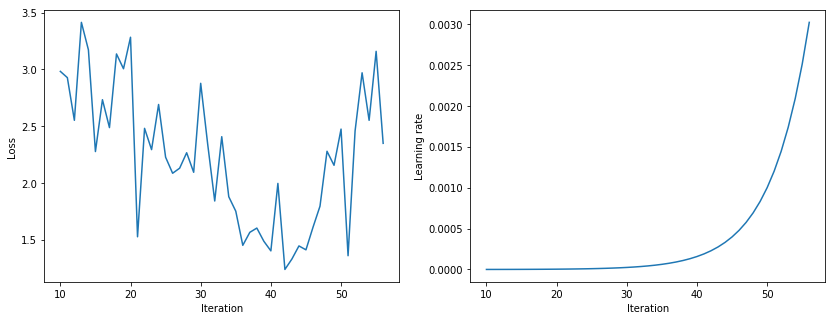

In [0]:
iters = range(len(lrs_log))
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(iters[10:-5], loss_log[10:-5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(iters[10:-5], lrs_log[10:-5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Learning rate')

Text(0, 0.5, 'Loss')

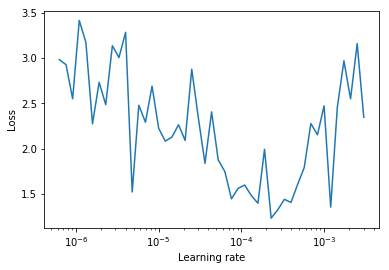

In [0]:
plt.plot(lrs_log[10:-5], loss_log[10:-5])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')

resnet-50 (pseudo label)

In [0]:
model = model.to(device)
lrs_log, loss_log = lr_range_test(train_loader, model, optimizer, is_pseudo=True)

minimum loss 1.575498104095459, at lr 0.0006918309709189362


Text(0, 0.5, 'Learning rate')

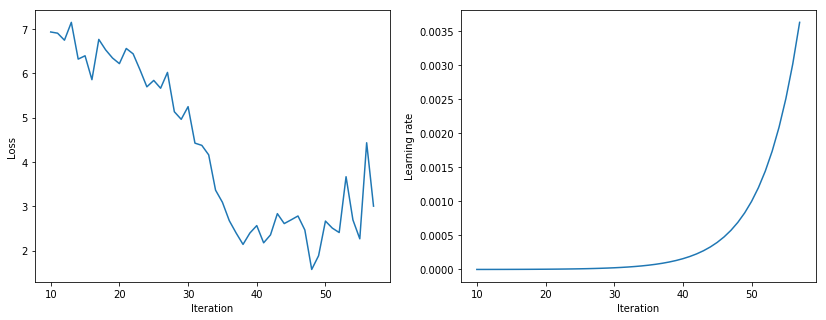

In [0]:
iters = range(len(lrs_log))
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(iters[10:-5], loss_log[10:-5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(iters[10:-5], lrs_log[10:-5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Learning rate')

Text(0, 0.5, 'Loss')

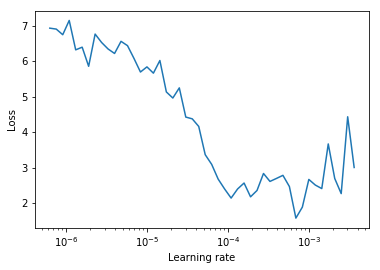

In [0]:
plt.plot(lrs_log[10:-5], loss_log[10:-5])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')

resnet-101

In [0]:
model = model.to(device)
lrs_log, loss_log = lr_range_test(train_loader, model, optimizer)

minimum loss 1.2257544994354248, at lr 0.0001584893192461114


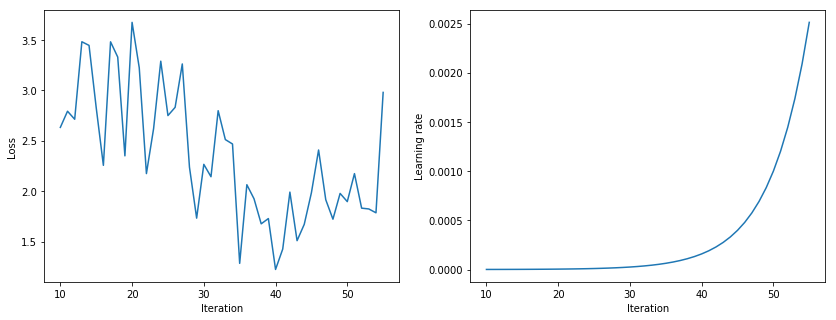

In [0]:
iters = range(len(lrs_log))
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(iters[10:-5], loss_log[10:-5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(iters[10:-5], lrs_log[10:-5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Learning rate');

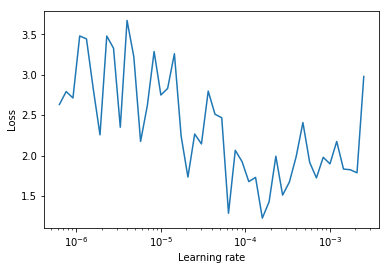

In [0]:
plt.plot(lrs_log[10:-5], loss_log[10:-5])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss');

### Scheduler for one-cycle

In [0]:
class OneCycleScheduler(object):

    def __init__(self, optimizer, epochs, train_loader, max_lr=3e-3,
                 moms=(.95, .85), div_factor=25, sep_ratio=0.3, final_div=None):

        self.optimizer = optimizer

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
            self.init_lrs = [lr/div_factor for lr in self.max_lrs]
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)
            self.init_lrs = [max_lr/div_factor] * len(optimizer.param_groups)

        if final_div is None: final_div = div_factor*1e4
        self.final_lrs = [lr/final_div for lr in self.max_lrs]
        self.moms = moms

        total_iteration = epochs * len(train_loader)
        self.up_iteration = int(total_iteration * sep_ratio)
        self.down_iteration = total_iteration - self.up_iteration

        self.curr_iter = 0
        self._assign_lr_mom(self.init_lrs, [moms[0]]*len(optimizer.param_groups))

    def _assign_lr_mom(self, lrs, moms):
        for param_group, lr, mom in zip(self.optimizer.param_groups, lrs, moms):
            param_group['lr'] = lr
            param_group['betas'] = (mom, 0.999)

    def _annealing_cos(self, start, end, pct):
        cos_out = np.cos(np.pi * pct) + 1
        return end + (start-end)/2 * cos_out

    def step(self):
        self.curr_iter += 1

        if self.curr_iter <= self.up_iteration:
            pct = self.curr_iter / self.up_iteration
            curr_lrs = [self._annealing_cos(min_lr, max_lr, pct) \
                            for min_lr, max_lr in zip(self.init_lrs, self.max_lrs)]
            curr_moms = [self._annealing_cos(self.moms[0], self.moms[1], pct) \
                            for _ in range(len(self.optimizer.param_groups))]
        else:
            pct = (self.curr_iter-self.up_iteration) / self.down_iteration
            curr_lrs = [self._annealing_cos(max_lr, final_lr, pct) \
                            for max_lr, final_lr in zip(self.max_lrs, self.final_lrs)]
            curr_moms = [self._annealing_cos(self.moms[1], self.moms[0], pct) \
                            for _ in range(len(self.optimizer.param_groups))]

        self._assign_lr_mom(curr_lrs, curr_moms)


### Training

In [0]:
def train(train_loader, model, optimizer, scheduler, is_pseudo=False):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param optimizer: optimizer
    :param scheduler: lr, mom scheduler
    """
    model.train()  # training mode enables dropout

    losses = AverageMeter()
    accs = AverageMeter()

    # Batches
    for i, (images, labels) in enumerate(train_loader):

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 224, 224)
        labels = labels.squeeze().to(device)

        # Forward prop.
        predicted_scores = model(images)  # (N, n_classes)

        # Loss
        if is_pseudo:
            loss = cross_entropy_with_probs(predicted_scores, labels)  # scalar
        else:
            loss = F.cross_entropy(predicted_scores, labels)  # scalar
        
        # Accuracy
        _, preds = predicted_scores.max(1)
        if is_pseudo:
            _, labels = labels.max(1)
        acc = float((preds == labels).sum()) / images.size(0)

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()
        losses.update(loss.item(), images.size(0))
        accs.update(acc, images.size(0))

        # Update lr, momentum per iteration
        scheduler.step()

        # Print status
        if i % 69 == 0:
            print('Iteration: [{0}/{1}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc {acc.val:.4f} ({acc.avg:.4f})\t'.format(i, len(train_loader),
                                                               loss=losses, acc=accs))


def validate(val_loader, model):
    """
    One epoch's validation.

    :param val_loader: DataLoader for validation data
    :param model: model

    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout

    losses = AverageMeter()
    accs = AverageMeter()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, (images, labels) in enumerate(val_loader):

            # Move to default device
            images = images.to(device)  # (N, 3, 224, 224)
            labels = labels.squeeze().to(device)

            # Forward prop.
            predicted_scores = model(images)  # (N, n_classes)
            _, preds = predicted_scores.max(1)

            # Loss
            loss = F.cross_entropy(predicted_scores, labels)
            losses.update(loss.item(), images.size(0))
            
            # Accuracy
            acc = float((preds == labels).sum()) / images.size(0)
            accs.update(acc, images.size(0))
            

    print('* Val Loss - {loss.avg:.3f}'.format(loss=losses))
    print('* Val Acc - {acc.avg:.3f}'.format(acc=accs))

    return losses.avg

#### one-cycle

In [0]:
epochs = 4
ft_lrs = [lr/100, lr/10, lr]

# init model, optimizer
model, optimizer = model_optimizer_init()
model = model.to(device)
scheduler = OneCycleScheduler(optimizer, epochs, train_loader, max_lr=ft_lrs)

In [0]:
%%time
for epoch in range(epochs):
    print(f'Epoch: {epoch+1}')
    start_time = time.time()

    # One epoch's training
    train(train_loader=train_loader,
          model=model,
          optimizer=optimizer,
          scheduler=scheduler)

    # One epoch's validation
    val_loss = validate(val_loader=val_loader,
                        model=model)

    # Did validation loss improve?
    if epoch==0: best_loss = val_loss
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    # Save checkpoint
    if is_best or epoch == 0:
        print(f'Save the better model at epoch {epoch+1}')
        torch.save(model.state_dict(), f'rn50_ft_epk_{epochs}.pth')
    
    time_elapsed = time.time() - start_time
    print('Time: {:.0f}:{:.0f}'.format(time_elapsed // 60, time_elapsed % 60))
    print()

Epoch: 1
Iteration: [0/208]	Loss 3.3000 (3.3000)	
Iteration: [69/208]	Loss 1.9282 (2.5805)	
Iteration: [138/208]	Loss 2.0488 (2.2208)	
Iteration: [207/208]	Loss 0.7868 (2.0121)	
* Val Loss - 1.526
* Val Acc - 0.468
Save the better model at epoch 1
Time: 2:14

Epoch: 2
Iteration: [0/208]	Loss 1.4936 (1.4936)	
Iteration: [69/208]	Loss 0.7426 (1.3780)	
Iteration: [138/208]	Loss 0.8795 (1.2709)	
Iteration: [207/208]	Loss 1.1528 (1.1911)	
* Val Loss - 1.073
* Val Acc - 0.638
Save the better model at epoch 2
Time: 2:14

Epoch: 3
Iteration: [0/208]	Loss 1.0845 (1.0845)	
Iteration: [69/208]	Loss 0.7457 (0.9296)	
Iteration: [138/208]	Loss 0.7475 (0.9255)	
Iteration: [207/208]	Loss 0.8064 (0.8836)	
* Val Loss - 0.890
* Val Acc - 0.716
Save the better model at epoch 3
Time: 2:13

Epoch: 4
Iteration: [0/208]	Loss 0.8359 (0.8359)	
Iteration: [69/208]	Loss 0.8712 (0.8248)	
Iteration: [138/208]	Loss 0.8194 (0.7776)	
Iteration: [207/208]	Loss 0.6754 (0.7675)	
* Val Loss - 0.859
* Val Acc - 0.721
Save 

In [0]:
epochs = 3
lr = 3e-4
ft_lrs = [lr/100, lr/10, lr]

# init model, optimizer
model, optimizer = model_optimizer_init()
model = model.to(device)
scheduler = OneCycleScheduler(optimizer, epochs, train_loader, max_lr=ft_lrs)

In [0]:
%%time

# pseudo labeling

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}')
    start_time = time.time()

    # One epoch's training
    train(train_loader=train_loader,
          model=model,
          optimizer=optimizer,
          scheduler=scheduler,
          is_pseudo=True)

    # One epoch's validation
    val_loss = validate(val_loader=val_loader,
                        model=model)

    # Did validation loss improve?
    if epoch==0: best_loss = val_loss
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    # Save checkpoint
    if is_best or epoch == 0:
        print(f'Save the better model at epoch {epoch+1}')
        torch.save(model.state_dict(), f'rn50_ft_epk_{epochs}_pl.pth')
    
    time_elapsed = time.time() - start_time
    print('Time: {:.0f}:{:.0f}'.format(time_elapsed // 60, time_elapsed % 60))
    print()

Epoch: 1
Iteration: [0/580]	Loss 7.4808 (7.4808)	Acc 0.0312 (0.0312)	
Iteration: [69/580]	Loss 1.6665 (3.8228)	Acc 0.6562 (0.1710)	
Iteration: [138/580]	Loss 1.8645 (2.8861)	Acc 0.6250 (0.3896)	
Iteration: [207/580]	Loss 1.6976 (2.5119)	Acc 0.5938 (0.4621)	
Iteration: [276/580]	Loss 1.6949 (2.3141)	Acc 0.7188 (0.5093)	
Iteration: [345/580]	Loss 2.0429 (2.1842)	Acc 0.6562 (0.5414)	
Iteration: [414/580]	Loss 1.5557 (2.0857)	Acc 0.8125 (0.5636)	
Iteration: [483/580]	Loss 1.5633 (2.0224)	Acc 0.6875 (0.5765)	
Iteration: [552/580]	Loss 1.3984 (1.9635)	Acc 0.8750 (0.5931)	
* Val Loss - 0.948
* Val Acc - 0.693
Save the better model at epoch 1
Time: 7:13

Epoch: 2
Iteration: [0/580]	Loss 1.4399 (1.4399)	Acc 0.6250 (0.6250)	
Iteration: [69/580]	Loss 1.4992 (1.4448)	Acc 0.9062 (0.7415)	
Iteration: [138/580]	Loss 1.4620 (1.4700)	Acc 0.7500 (0.7347)	
Iteration: [207/580]	Loss 1.5710 (1.4558)	Acc 0.5938 (0.7375)	
Iteration: [276/580]	Loss 1.1822 (1.4460)	Acc 0.8750 (0.7378)	
Iteration: [345/580]	Los

#### n-fold training

In [0]:
epochs = 4
ft_lrs = [lr/100, lr/10, lr]
nb_folds = 5

In [0]:
%%time

for i in range(nb_folds):
    print(f'Fold: {i+1}')
    print()
    
    # init model, optimizer
    model, optimizer = model_optimizer_init()
    model = model.to(device)
    
    # custom dataloaders
    train_dataset = NCFMclass(data_path, split='train', which_fold=i, nb_folds=nb_folds)
    val_dataset = NCFMclass(data_path, split='valid', which_fold=i, nb_folds=nb_folds)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                            num_workers=workers)
    
    # lr scheduler
    scheduler = OneCycleScheduler(optimizer, epochs, train_loader, max_lr=ft_lrs)
    
    
    for epoch in range(epochs):
        print(f'Epoch: {epoch+1}')
        start_time = time.time()

        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              optimizer=optimizer,
              scheduler=scheduler)

        # One epoch's validation
        val_loss = validate(val_loader=val_loader,
                            model=model)

        # Did validation loss improve?
        if epoch==0: best_loss = val_loss
        is_best = val_loss < best_loss
        best_loss = min(val_loss, best_loss)

        # Save checkpoint
        if is_best or epoch == 0:
            print(f'Save the better model at epoch {epoch+1}')
            torch.save(model.state_dict(), f'rn50_ft_epk_{epochs}_fld_{i}.pth')

        time_elapsed = time.time() - start_time
        print('Time: {:.0f}:{:.0f}'.format(time_elapsed // 60, time_elapsed % 60))
        print()
    
    print()

Fold: 1

Epoch: 1
Iteration: [0/187]	Loss 4.1809 (4.1809)	Acc 0.1250 (0.1250)	
Iteration: [69/187]	Loss 1.4475 (2.9527)	Acc 0.5625 (0.2022)	
Iteration: [138/187]	Loss 1.6536 (2.3978)	Acc 0.4375 (0.3210)	
* Val Loss - 1.538
* Val Acc - 0.475
Save the better model at epoch 1
Time: 2:37

Epoch: 2
Iteration: [0/187]	Loss 1.4415 (1.4415)	Acc 0.5000 (0.5000)	
Iteration: [69/187]	Loss 1.5603 (1.4597)	Acc 0.4688 (0.5080)	
Iteration: [138/187]	Loss 1.2380 (1.3718)	Acc 0.6250 (0.5364)	
* Val Loss - 1.095
* Val Acc - 0.636
Save the better model at epoch 2
Time: 2:38

Epoch: 3
Iteration: [0/187]	Loss 1.0194 (1.0194)	Acc 0.7188 (0.7188)	
Iteration: [69/187]	Loss 1.0866 (1.0449)	Acc 0.5625 (0.6397)	
Iteration: [138/187]	Loss 0.9339 (1.0183)	Acc 0.5938 (0.6495)	
* Val Loss - 0.937
* Val Acc - 0.693
Save the better model at epoch 3
Time: 1:41

Epoch: 4
Iteration: [0/187]	Loss 1.1026 (1.1026)	Acc 0.5625 (0.5625)	
Iteration: [69/187]	Loss 0.8486 (0.8573)	Acc 0.6250 (0.7058)	
Iteration: [138/187]	Loss 1.

### Inference

In [0]:
def get_preds(test_loader, model):
    """
    One epoch's validation.

    :param test_loader: DataLoader for test data
    :param model: model

    :return: predictions and file_names
    """
    model.eval()  # eval mode disables dropout

    file_names = []
    predictions = []
    with torch.no_grad():
        # Batches
        for i, (images, fnames) in enumerate(test_loader):
            file_names.extend(fnames)

            # Move to default device
            images = images.to(device)  # (N, 3, 224, 224)

            # Forward prop.
            predicted_scores = model(images)  # (N, n_classes)
            
            predictions.append(predicted_scores)
    
    predictions = F.softmax(torch.cat(predictions, 0), 1)

    return predictions, file_names


def TTA(test_datasets, model, beta=0.4):
    """
    Test time augmentation prediction
    
    Inputs:
    - test_datasets: list of original/transformed datasets
    - model: classifier
    - beta: param for ratio of pred of original dataset in final results
    
    Return:
    - predictions and file_names
    """
    original_pred = 0
    transformed_pred = 0
    for i in range(len(test_datasets)):
        test_loader = DataLoader(test_datasets[i], batch_size=batch_size,
                                 shuffle=False, num_workers=workers)
        preds, file_names = get_preds(test_loader, model)
        if i == 0:
            original_pred += preds.cpu().numpy()
        else:
            transformed_pred += preds.cpu().numpy() / (len(test_datasets)-1)
    
    predictions = beta * original_pred + (1-beta) * transformed_pred
    
    return predictions, file_names

Single prediction

In [0]:
%%time
preds, file_names = get_preds(test_loader, model)

CPU times: user 28 s, sys: 14.3 s, total: 42.4 s
Wall time: 1min 37s


In [0]:
%%time

# 5-fold prediction
os.chdir('/content/drive/My Drive/DL_projects/cv_fish')
net = models.resnet50(pretrained=True)
model = ResNetFish(net)

preds = []
for i in range(5):
    model.load_state_dict(torch.load(f'rn50_ft_epk_4_fld_{i}.pth'))
    model = model.to(device)
    prediction, file_names = get_preds(test_loader, model)
    preds.append(prediction)

preds = torch.stack(preds).mean(0)

CPU times: user 1min 31s, sys: 24.9 s, total: 1min 56s
Wall time: 8min 16s


In [0]:
file_names = [f if f.split('_')[0]=='img' else 'test_stg2/'+f for f in file_names]
submission = pd.DataFrame(preds.cpu().numpy(), columns=label_clss)
submission['image'] = file_names
submission.to_csv('submission.csv', index=False)

TTA

In [0]:
tsfm = T.Compose([
                    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
                    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
                    T.RandomHorizontalFlip(),
                    T.RandomAffine(degrees=10, shear=10),
                    T.ToTensor(),
                    T.Normalize(rgb_mean, rgb_std),
                ])

test_datasets = [NCFMclass(data_path, split='test')] + [NCFMclass(data_path, split='test', transform=tsfm)]*6

In [0]:
%%time
preds, file_names = TTA(test_datasets, model)

CPU times: user 2min 10s, sys: 1min 5s, total: 3min 15s
Wall time: 37min 55s


In [0]:
%%time

# 5-fold prediction
os.chdir('/content/drive/My Drive/DL_projects/cv_fish')
net = models.resnet50(pretrained=True)
model = ResNetFish(net)

preds = []
for i in range(5):
    model.load_state_dict(torch.load(f'rn50_ft_epk_4_fld_{i}.pth'))
    model = model.to(device)
    prediction, file_names = TTA(test_datasets, model)
    preds.append(prediction)

preds = np.mean(preds, 0)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 42734901.26it/s]


CPU times: user 5min 40s, sys: 2min 44s, total: 8min 25s
Wall time: 3h 37min 49s


In [0]:
file_names = [f if f.split('_')[0]=='img' else 'test_stg2/'+f for f in file_names]
submission = pd.DataFrame(preds, columns=label_clss)
submission['image'] = file_names
submission.to_csv('submission.csv', index=False)

Submit to Kaggle

In [0]:
!kaggle competitions submit -c the-nature-conservancy-fisheries-monitoring -f submission.csv -m "ssd400, 8 epochs, resnet50, 5-fold, TTA"

100% 1.47M/1.47M [00:02<00:00, 744kB/s]
Successfully submitted to The Nature Conservancy Fisheries Monitoring

In [0]:
!kaggle competitions submit -c the-nature-conservancy-fisheries-monitoring -f submission.csv -m "yolov3, 2700 iters, resnet50, 5-fold, TTA"

100% 1.47M/1.47M [00:00<00:00, 4.21MB/s]
Successfully submitted to The Nature Conservancy Fisheries Monitoring

In [0]:
!kaggle competitions submit -c the-nature-conservancy-fisheries-monitoring -f submission.csv -m "maskrcnn-benchmark, 5000 iters, resnet50, 5-fold, TTA"

100% 1.47M/1.47M [00:01<00:00, 923kB/s]
Successfully submitted to The Nature Conservancy Fisheries Monitoring